In [25]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [26]:
# Забираем данные

dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').strftime('%Y-%m-%d')

df_sales = pd.DataFrame({
    'date': dates,
    'sales': [5350, 5450, 5500, 4500, 4400, 3900, 3800, 4000, 4500, 4900, 5000, 5500]
})



In [27]:

"""
  Формирование таблицы по ключевым ставкам

  parse_date - парсит дату из исходной таблицы в формат, требуемый для url сайт ЦБ

"""

def parse_date(date):
  date = date.split('-')[::-1]
  return '.'.join(date)

date_end = (pd.to_datetime(dates[-1]) + pd.DateOffset(months=1)).strftime('%d.%m.%Y')

date_start = parse_date(dates[0])




url = f'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From={date_start}&UniDbQuery.To={date_end}'

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
dates_table = soup.find('table', class_='data')

data_rates = {}

rates_date = dates_table.find_all('tr')
for index, rate_date in enumerate(rates_date):
  if index == 0:
    continue
  _, date, rate, _ = rate_date.text.split('\n')
  rate = float(rate.replace(',', '.'))
  date = date.split('.')
  if 'Day' not in data_rates:
    data_rates['Day'], data_rates['Month'], data_rates['Year'], data_rates['Rate'] = [date[0]], [date[1]], [date[2]], [rate]
  else:
    data_rates['Day'].append(date[0])
    data_rates['Month'].append(date[1])
    data_rates['Year'].append(date[2])
    data_rates['Rate'].append(rate)
df_rates = pd.DataFrame(data_rates)

In [28]:
df_rates = df_rates.groupby(['Month', 'Year'])['Rate'].max().reset_index()

In [29]:
df_rates['date'] = pd.to_datetime(df_rates['Year'].astype(str) + '-' + df_rates['Month'] + '-01')

In [30]:

df_sales['date'] = pd.to_datetime(df_sales['date'])

df_rates['date'] = pd.to_datetime(
    df_rates['Year'].astype(str) + '-' + df_rates['Month'] + '-01'
)


table_result = pd.merge(
    df_sales,
    df_rates[['date', 'Rate']],
    on='date',
    how='left'
)

table_result.to_excel('Таблица ключевых ставок и продаж.xlsx', index=False)


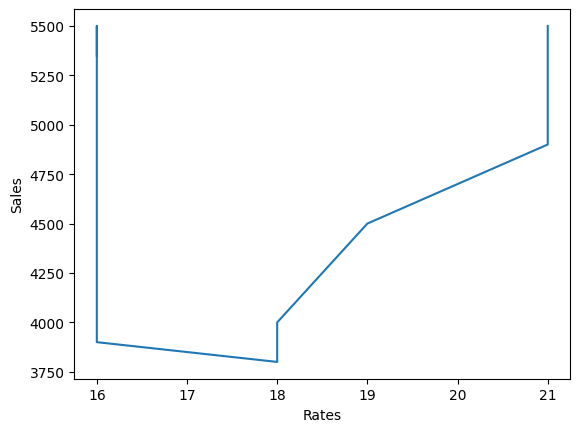

In [31]:
plt.plot(table_result['Rate'], table_result['sales'])
plt.xlabel('Rates')
plt.ylabel('Sales')
plt.show()

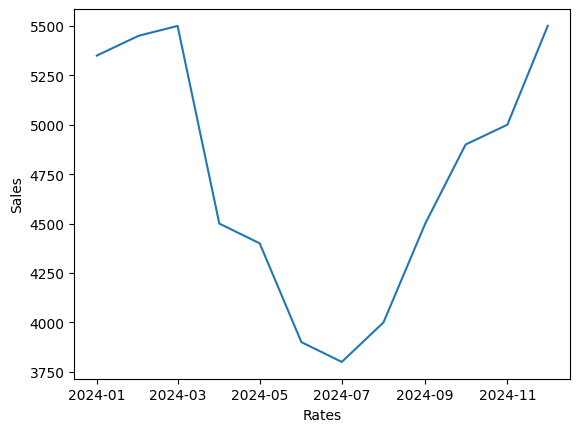

In [32]:
plt.plot(table_result['date'], table_result['sales'])
plt.xlabel('Rates')
plt.ylabel('Sales')
plt.show()